In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils
import gpfunctions as gp
import lstm_model

In [2]:
import matplotlib.pylab as pylab
params = {
    'axes.labelsize': 'xx-large',
    'xtick.labelsize':'xx-large',
    'ytick.labelsize':'xx-large'
}
pylab.rcParams.update(params)

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
LOSS_FUNCS = ['MIN', 'OI', 'SUM']

In [5]:
def average_min_found_values_across_rows(values):
    return np.mean(np.apply_along_axis(utils.min_up_to_k, 1, values), axis=0)

def find_y_randomly(X_test, A_test, min_test, max_test, dim, kernel, n_test=2000, n_steps=20, n_bumps=6.0):
    params = {
        'function': gp.benchmark_prior5,
        'kernel': gp.kernel_function(kernel),
        'dim': dim,
        'l': 2/n_bumps*np.sqrt(dim),
        'n_steps': n_steps+1,
        'n_test': n_test,
        'X_test': X_test,
        'A_test': A_test,
        'min_test': min_test,
        'max_test': max_test
    }
    return lstm_model.get_random_baseline(**params)

In [6]:
def find_y_from_lstm(X_test, A_test, min_test, max_test, kernel, dim, loss, n_steps=20, debug=False):
    
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]


    data_Xt = X_test
    data_At  = A_test
    data_mint = min_test.reshape(-1,1)
    data_maxt = max_test.reshape(-1,1)

    model_params = lstm_model.load_model_params(model, debug=False)

    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': n_steps,
            'l': model_params['gp_length'],
            'scope': model_params['scope'],
            'kernel': gp.rbf_kernel, 
            'function': gp.benchmark_prior5
        }

        Xt, At, mint, maxt, samples_x, samples_y, x_0, _, _ = lstm_model.build_training_graph(**params_dict)

        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt,
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array(starting_point).reshape(1,-1)
        }

        res = sess.run(samples_y, feed_dict=feed_dict)

        return np.array(res).reshape(n_steps+1,-1).T

# print(model_name)
# compute_y_from_all_testing_data(utils.)
# compute_y_from_all_testing_data(model_name, dim=1, kernel='rbf', starting_point=[-1])

In [7]:
def plot_min_comparison_of_dim_and_kernel(dim, kernel, steps=21, xtick_step=2, suffix=""):
    
    # load SKOPT
    for method in ['gp', 'gbrt', 'forest', 'basinhopping']:
        skopt_y = np.load('./skopt-result/%s/%dd-%s-samples_y%s.npy' % (method, dim, kernel,suffix))
        skopt_y = average_min_found_values_across_rows(skopt_y)[:steps]
        key = 'SKOPT-%s' % method.upper()
        if method is 'basinhopping':
            key = 'SCIPY-%s' % method.upper()
        plt.plot(skopt_y, label=key)
    
    # load test data
    X_test, A_test, min_test, max_test = utils.loadData(dim, 'testing', kernel)
    
    # load RANDOM    
    random_y = find_y_randomly(X_test, A_test, min_test, max_test, dim, kernel, n_steps=steps-1)
    random_y = average_min_found_values_across_rows(random_y)
    plt.plot(random_y, label='RANDOM')
    
    # load LSTM data
    for loss in LOSS_FUNCS:
        y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernel, loss=loss, n_steps = steps - 1)
        y_values = average_min_found_values_across_rows(y_values)
        plt.plot(y_values, label='LSTM-%s'%loss, marker = 'o')
    
    # using model trained on different kernel
    kernelb = 'rbf' if kernel is 'matern32' else 'matern32'
    y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernelb, loss='MIN',  n_steps = steps - 1)
    y_values = average_min_found_values_across_rows(y_values)

    plt.plot(y_values, label='LSTM-%s-%s'%('MIN',kernelb), marker = '^')

    
    xticks = range(0, steps, xtick_step)
    yticks = np.arange(-1.2, 0.2, 0.2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.title('%dD-%s' % (dim, kernel.upper()))

def plot_comparision_of_dim(dim):
    kernels = ['rbf', 'matern32']
    plt.figure(figsize=(15,4))
    
    for i in range(len(kernels)):
        plt.subplot(1,2,i+1)
        plot_min_comparison_of_dim_and_kernel(dim=dim, kernel=kernels[i])

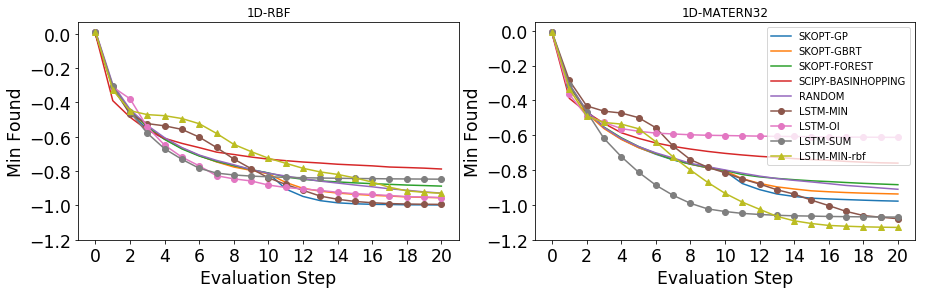

In [8]:
plot_comparision_of_dim(dim=1)
plt.legend()

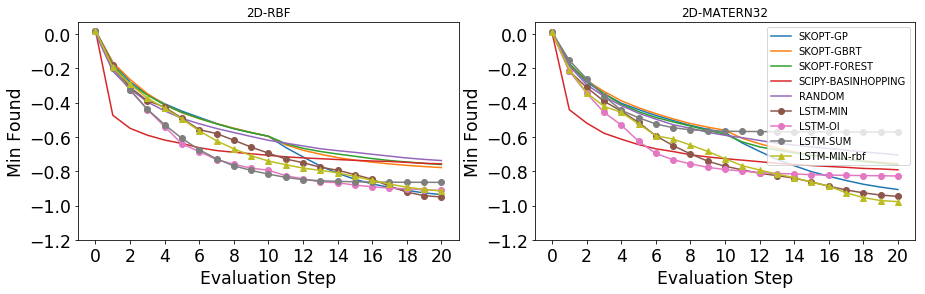

In [260]:
plot_comparision_of_dim(dim=2)
plt.legend()

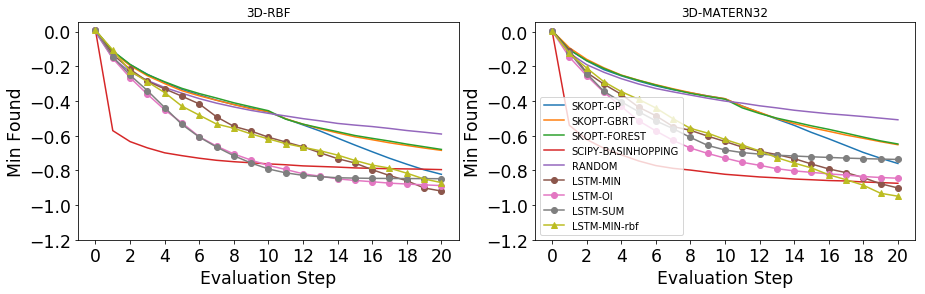

In [261]:
plot_comparision_of_dim(dim=3)
plt.legend()

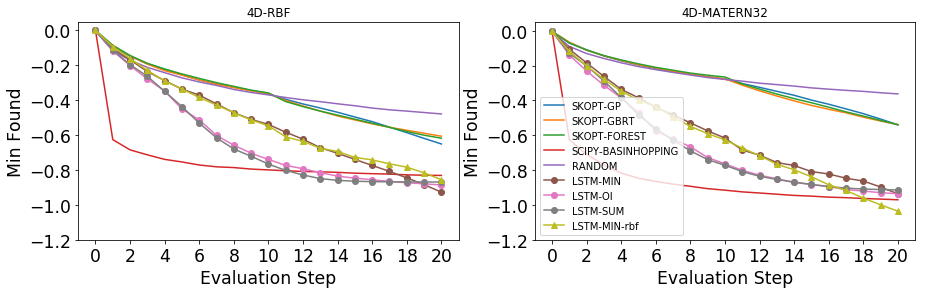

In [262]:
plot_comparision_of_dim(dim=4)
plt.legend()

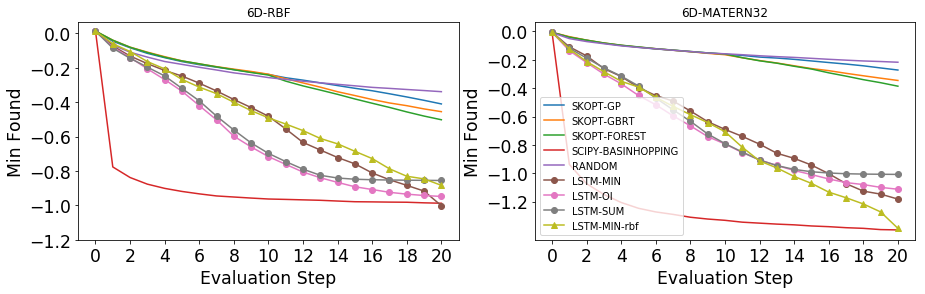

In [264]:
plot_comparision_of_dim(dim=6)
plt.legend()

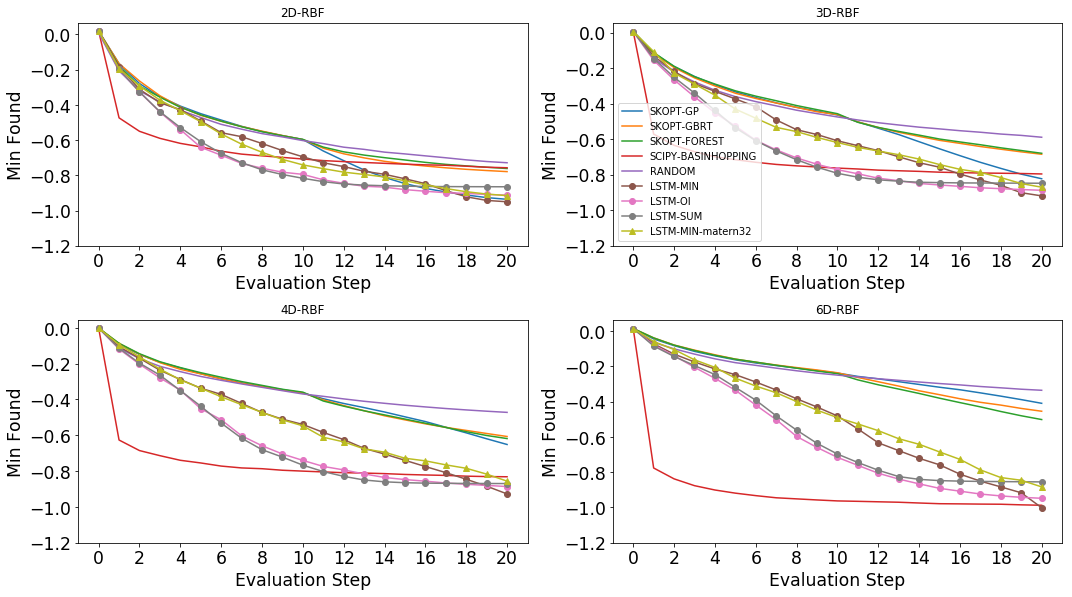

In [270]:
def plot_for_poster(kernel='rbf'):
    dims = [2,3,4,6]
    total_dims = len(dims)
    plt.figure(figsize=(15,4*total_dims))
    count = 0
    for d in range(total_dims):
        dim = dims[d]

        plt.subplot(total_dims,2,count+1)
        plot_min_comparison_of_dim_and_kernel(dim=dim, kernel=kernel)

        if count == 1:
            plt.legend()
        count = count + 1
    plt.tight_layout()
plot_for_poster()

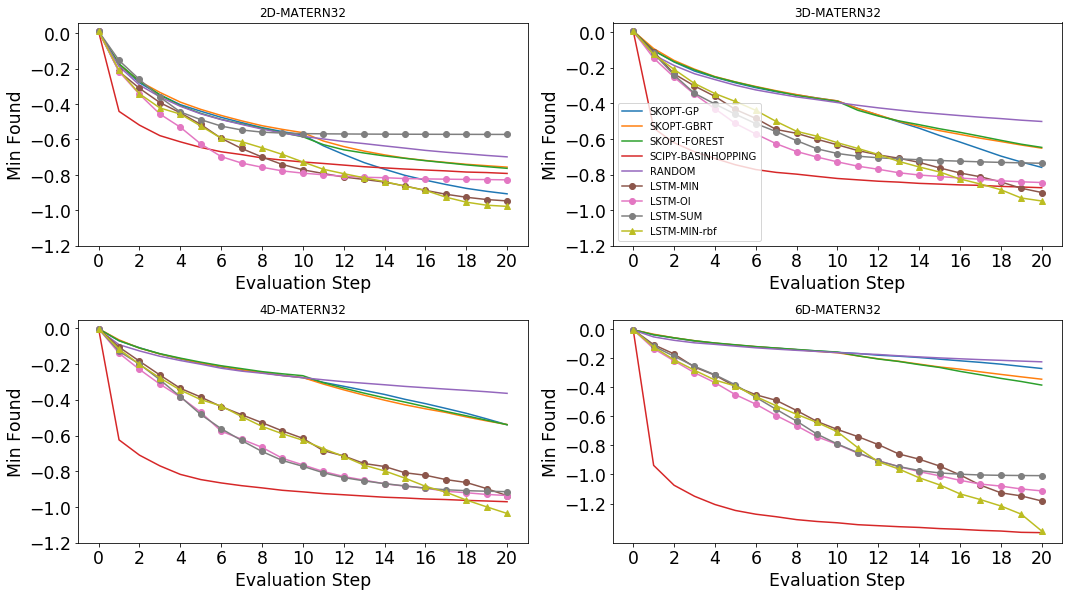

In [271]:
plot_for_poster(kernel="matern32")

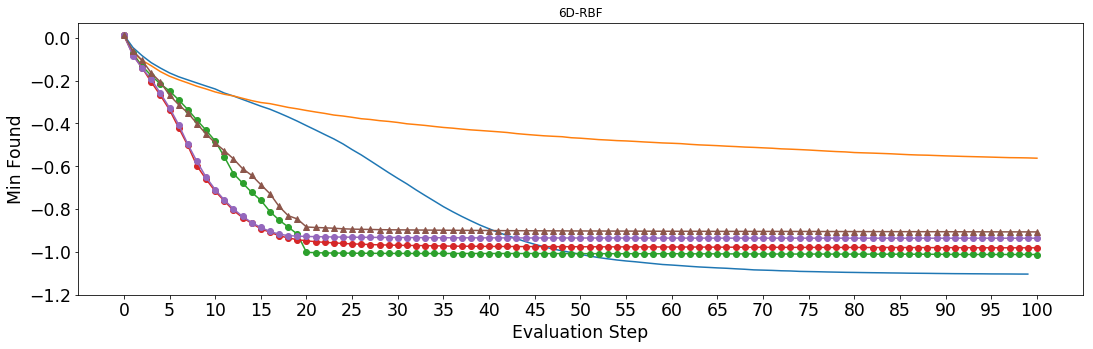

In [225]:
plt.figure(figsize=(18,5))
plot_min_comparison_of_dim_and_kernel(dim=6, kernel='rbf', steps=101, xtick_step=5)


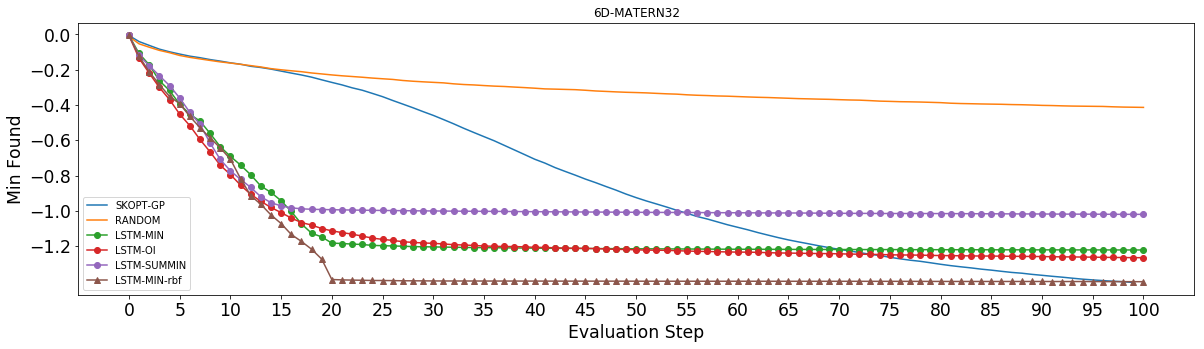

In [227]:
plt.figure(figsize=(20,5))

plot_min_comparison_of_dim_and_kernel(dim=6, kernel='matern32', steps=101, xtick_step=5)
plt.legend()

## Obsoleted code

In [245]:
basin_y = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % ('basinhopping', 2, 'rbf'))
basin_x = np.load('./skopt-result/%s/%dd-%s-samples_x.npy' % ('basinhopping', 2, 'rbf'))

In [255]:
basin_y_mat = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % ('basinhopping', 2, 'matern32'))
basin_x_mat = np.load('./skopt-result/%s/%dd-%s-samples_x.npy' % ('basinhopping', 2, 'matern32'))

basin_y_gp_rbf = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % ('gp', 2, 'rbf'))
basin_x_gp_rbf = np.load('./skopt-result/%s/%dd-%s-samples_x.npy' % ('gp', 2, 'rbf'))

In [253]:
basin_y[:,0]

array([ 0.35546616,  0.97240353,  0.5617635 ,  0.82357059, -0.41012341,
       -0.03331374, -0.54592131, -0.15532204,  0.24189975, -0.19397074,
        0.14363468, -0.11583034,  0.4280172 ,  0.06514029, -0.10325337,
        0.30310038,  0.35423299,  0.09226409, -0.24614087,  0.17177403])

In [254]:
basin_y_mat[:,0]

array([-0.08676101,  0.48933346,  0.21815733,  0.10169803, -0.98775093,
        0.41611909, -0.21771529,  0.15215692, -0.76424528,  0.32774738,
        0.19149432,  0.06352932, -0.12455736,  0.87687765,  0.01450334,
       -0.40246971, -0.22844155,  0.02302684, -0.05686894,  0.04977946])

In [256]:
basin_y_gp_rbf[:,0]

array([ 0.35546616,  0.97240353,  0.5617635 , ..., -0.02558308,
       -0.09356291,  0.08135814])

In [215]:
def pppp(dim, kernel, steps=21):
    
    # load SKOPT
#     for method in ['gp', 'gbrt', 'forest']:
    for method in ['gp']:
        skopt_y = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % (method, dim, kernel))
        skopt_y = average_min_found_values_across_rows(skopt_y)[:steps]
        key = 'SKOPT-%s' % method.upper()
        plt.plot(skopt_y, label=key)
    
    # load test data
    X_test, A_test, min_test, max_test = utils.loadData(dim, 'testing', kernel)
    

    # load LSTM data
    for loss in LOSS_FUNCS:
        y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernel, loss=loss, n_steps = steps - 1)
       
        y_values = average_min_found_values_across_rows(y_values)
#         if loss is 'MIN':
#             print(y_values)
        plt.plot(y_values, label='LSTM-%s'%loss, marker = 'o')
    
    # using model trained on different kernel
    kernelb = 'rbf' if kernel is 'matern32' else 'matern32'
    y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernelb, loss='MIN', n_steps = steps - 1)
    y_values = average_min_found_values_across_rows(y_values)

    plt.plot(y_values, label='LSTM-%s-%s'%('MIN',kernelb), marker = '^')

    
#     xticks = range(0, steps, 2)
    yticks = np.arange(-1.2, 0.2, 0.2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
#     plt.xticks(xticks)
    plt.yticks(yticks)
    plt.title('%dD-%s' % (dim, kernel.upper()))
    
# plt.figure(figsize=(20,5))
# pppp(dim=6, kernel='rbf', steps=101)
# plt.legend()




In [104]:
def find_xy_from_lstm(X_test, A_test, min_test, max_test, kernel, dim, loss, n_steps=20, debug=False):
    
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]


    data_Xt = X_test
    data_At  = A_test
    data_mint = min_test.reshape(-1,1)
    data_maxt = max_test.reshape(-1,1)

    model_params = lstm_model.load_model_params(model, debug=False)

    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }

        Xt, At, mint, maxt, samples_x, samples_y, x_0, _, _ = lstm_model.build_training_graph(**params_dict)

        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt,
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array(starting_point).reshape(1,-1)
        }

        y,x = sess.run([samples_y,samples_x], feed_dict=feed_dict)

        return y,x
X_test, A_test, min_test, max_test = utils.loadData(6, 'testing', 'rbf')
sy, sx = find_xy_from_lstm(X_test, A_test, min_test, max_test, 'rbf', 6, 'MIN')

In [170]:
np.array(sx)[2, 0,:]

array([ 0.14311759,  0.17867133, -0.08654706,  0.25449374,  0.58717263,
       -0.42871866], dtype=float32)

In [162]:
np.array(sy)[:5,0,:]

array([[ 0.32833433],
       [ 0.15137672],
       [-0.1297307 ],
       [-0.19622815],
       [-0.05825597]], dtype=float32)

In [163]:
idx = 0
length = 2/(6.0)*np.sqrt(6)

# data = np.array([-1]*6)
    data = np.array(sx)[:5, idx,:].reshape(1,1,6)
# data = np.array(sx)[:5, 0,:]
# print(data.shape)
gp.normalized_gp_function('np', X_test[np.newaxis, idx], A_test[np.newaxis, idx], min_test[np.newaxis, idx], max_test[np.newaxis, idx], \
    length, gp.kernel_function('rbf'), data)

array([[ 0.3283343 ,  0.15137662, -0.12973068, -0.19622818, -0.05825595]])

In [151]:
gp.rbf_kernel('np', np.array([1,1,1,1]).reshape(1,1,4), np.array([0,0,0,0]).reshape(1,1,4), 1)

array([[[ 0.01831564]]])

In [153]:
np.exp(-1* np.sum(np.power((np.array([1,1,1,1]) - np.array([0,0,0,0])),2) ))

0.018315638888734179

In [160]:
with tf.Session() as sess:
    x1 = tf.placeholder(tf.float32, [1,1,4])
    x2 = tf.placeholder(tf.float32, [1,1,4])
#     x2 = tf.Variable(4)
    
#         x_0 = tf.placeholder(tf.float32, [1,dim])

    rbf = gp.rbf_kernel('tf', x1, x2, 1)
    
    y  = sess.run(rbf, feed_dict={x1: np.array([1,1,1,1]).reshape(1,1,4), x2: np.array([1,1,1,1]).reshape(1,1,4)})

In [174]:
fun = lambda x, i : np.asscalar(gp.normalized_gp_function("np", X_test[np.newaxis,i], A_test[np.newaxis,i],\
                        min_test[np.newaxis,i], max_test[np.newaxis,i], length, gp.kernel_function('rbf'), \
                        np.array(x)[np.newaxis,np.newaxis,:]))
fun( np.array(sx)[4, 0,:], 0 )

-0.058255947018677645

In [173]:
np.array(sy)[:5,0,:]

array([[ 0.32833433],
       [ 0.15137672],
       [-0.1297307 ],
       [-0.19622815],
       [-0.05825597]], dtype=float32)